# Assignment 04 - Transfer Learning and Bounding Boxes and YOLOV8

# Part1: Using available pre-trained models for object detection, conduct inference on a short video (5-10 seconds) of a street scene drawing bounding boxes around detected vehicles.

## Step 1. Collect a source video. It may be necessary to divide the video into discrete image frames.
## Step 2. Conduct inference on each frame of the video, drawing bounding boxes around detected vehicles.
## Step 3. Format the results back into a video.
Use either Pytorch or Tensorflow.
Upload a .zip file containing your .ipynb notebook containing the code utilized and two video files: before
inference (without bounding boxes) and after inference (with bounding boxes

In [1]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [2]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
  # Source: https://upload.wikimedia.org/wikipedia/commons/7/72/GB_London_Street_View_12.jpg
  'Street' : 'https://upload.wikimedia.org/wikipedia/commons/7/72/GB_London_Street_View_12.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

In [ ]:
%%bash
git clone --depth 1 https://github.com/tensorflow/models
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


In [4]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [5]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [6]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'Faster R-CNN ResNet50 V1 640x640' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Faster R-CNN ResNet50 V1 640x640
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1


In [32]:
! pip install opencv-python==4.9.0.80

In [50]:
import cv2

def extract_frames(video_path, output_folder):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read and save frames until the video ends
    frame_count = 0
    while True:
        ret, frame = cap.read()
        print(ret, frame)
        if not ret:
            break

        # Save the frame
        frame_count += 1
        frame_path = f"{output_folder}/frame_{frame_count:04d}.jpg"
        cv2.imwrite(frame_path, frame)
        print(f"Frame {frame_count} saved as {frame_path}")

    cap.release()

# ! wget https://github.com/anjali-ojha/deep-learning/blob/main/assignment/assignment-4/video5.mp4
# Example usage
video_path = "/content/video5.mp4"
output_folder = "/content/output_frames"
extract_frames(video_path, output_folder)

Error: Could not open video.


# Tagging

In [ ]:
! rm -rf frames*
! wget https://github.com/anjali-ojha/deep-learning/raw/main/assignment/assignment-4/frames.zip
! ls -lrth
! unzip frames.zip


In [60]:
!unzip frames.zip frames

Archive:  frames.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of frames.zip or
        frames.zip.zip, and cannot find frames.zip.ZIP, period.


In [63]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



In [ ]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'Faster R-CNN ResNet152 V1 640x640' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))


In [73]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


In [90]:
def predict(image_np):

    # running inference
    results = hub_model(image_np)

    # different object detection models have additional results
    # all of them are explained in the documentation
    result = {key:value.numpy() for key,value in results.items()}
    print(result.keys())

    label_id_offset = 0
    image_np_with_detections = image_np.copy()

    # Use keypoints if available in detections
    keypoints, keypoint_scores = None, None
    if 'detection_keypoints' in result:
        keypoints = result['detection_keypoints'][0]
        keypoint_scores = result['detection_keypoint_scores'][0]

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections[0],
        result['detection_boxes'][0],
        (result['detection_classes'][0] + label_id_offset).astype(int),
        result['detection_scores'][0],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False,
        # keypoints=keypoints,
        # keypoint_scores=keypoint_scores,
        )

    return image_np_with_detections[0]

def show_image(image):
    plt.figure(figsize=(24,32))
    plt.imshow(image)
    plt.show()


In [ ]:
import os
import shutil

# Define input and output directories
input_folder = 'frames'
output_folder = 'output_frames'

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

i = 0
# Iterate over files in the input folder
for filename in sorted(os.listdir(input_folder)):
    input_file_path = f'{input_folder}/{filename}'
    output_file_path = f"output_frames/{filename}"
    print(input_file_path)

    i += 1
    if i%10 != 1:
        continue

    if filename.endswith('.jpg'):  # Process only text files, adjust as needed
        # Read content from input file
        img = load_image_into_numpy_array(input_file_path)
        print(img.shape)
        tagged_img = predict(img)

        # Convert the NumPy array to a PIL image
        image = Image.fromarray(tagged_img)

        # Save the image as a JPEG file
        image.save(output_file_path)

        print(f"Processed {input_file_path} and wrote to {output_file_path}")

    if i == 1:
        show_image(tagged_img)


print("Processing complete.")


In [78]:
def images_to_video(image_folder, output_video_path, fps=25):
    # Get list of image files in the folder
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]

    # Sort the image files based on their names
    image_files.sort()

    # Read the first image to get dimensions
    img = cv2.imread(image_files[0])
    height, width, _ = img.shape

    # Create video writer object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Specify the codec
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Write each image to the video writer
    for image_file in image_files:
        img = cv2.imread(image_file)
        out.write(img)

    # Release the video writer
    out.release()

# Example usage
image_folder = "output_frames"
output_video_path = "output_video.mp4"
images_to_video(image_folder, output_video_path)

In [103]:
# def predict(image_np):

#     # running inference
#     results = hub_model(image_np)

#     # different object detection models have additional results
#     # all of them are explained in the documentation
#     result = {key:value.numpy() for key,value in results.items()}
#     print(result.keys())

#     label_id_offset = 0
#     image_np_with_detections = image_np.copy()

#     # Filter detections to only include vehicles (assuming vehicles have class ID 3)
#     vehicle_indices = np.where(result['detection_classes'][0] == 3)[0]
#     vehicle_boxes = result['detection_boxes'][0][vehicle_indices]
#     vehicle_scores = result['detection_scores'][0][vehicle_indices]
#     class_labels = ['vehicle' for _ in vehicle_indices]

#     print(vehicle_scores)
#     viz_utils.visualize_boxes_and_labels_on_image_array(
#         image_np_with_detections[0],
#         vehicle_boxes,
#         np.ones_like(vehicle_indices) * 3,  # Class ID for vehicles
#         vehicle_scores,
#         category_index,
#         use_normalized_coordinates=True,
#         max_boxes_to_draw=200,
#         min_score_thresh=.30,  # Adjust this threshold as needed
#         agnostic_mode=False,
#     )

#     plt.figure(figsize=(24,32))
#     plt.imshow(image_np_with_detections[0])
#     plt.show()
#     return image_np_with_detections[0]


def predict(image_np):

    # running inference
    results = hub_model(image_np)

    # different object detection models have additional results
    # all of them are explained in the documentation
    result = {key:value.numpy() for key,value in results.items()}
    print(result.keys())

    label_id_offset = 0
    image_np_with_detections = image_np.copy()
    return result, image_np_with_detections



img = load_image_into_numpy_array('frames/frame_0001.jpg')
print(img.shape)
result, image_np_with_detections  = predict(img)


(1, 360, 640, 3)
dict_keys(['detection_classes', 'detection_boxes', 'raw_detection_scores', 'detection_scores', 'detection_multiclass_scores', 'raw_detection_boxes', 'num_detections', 'detection_anchor_indices'])


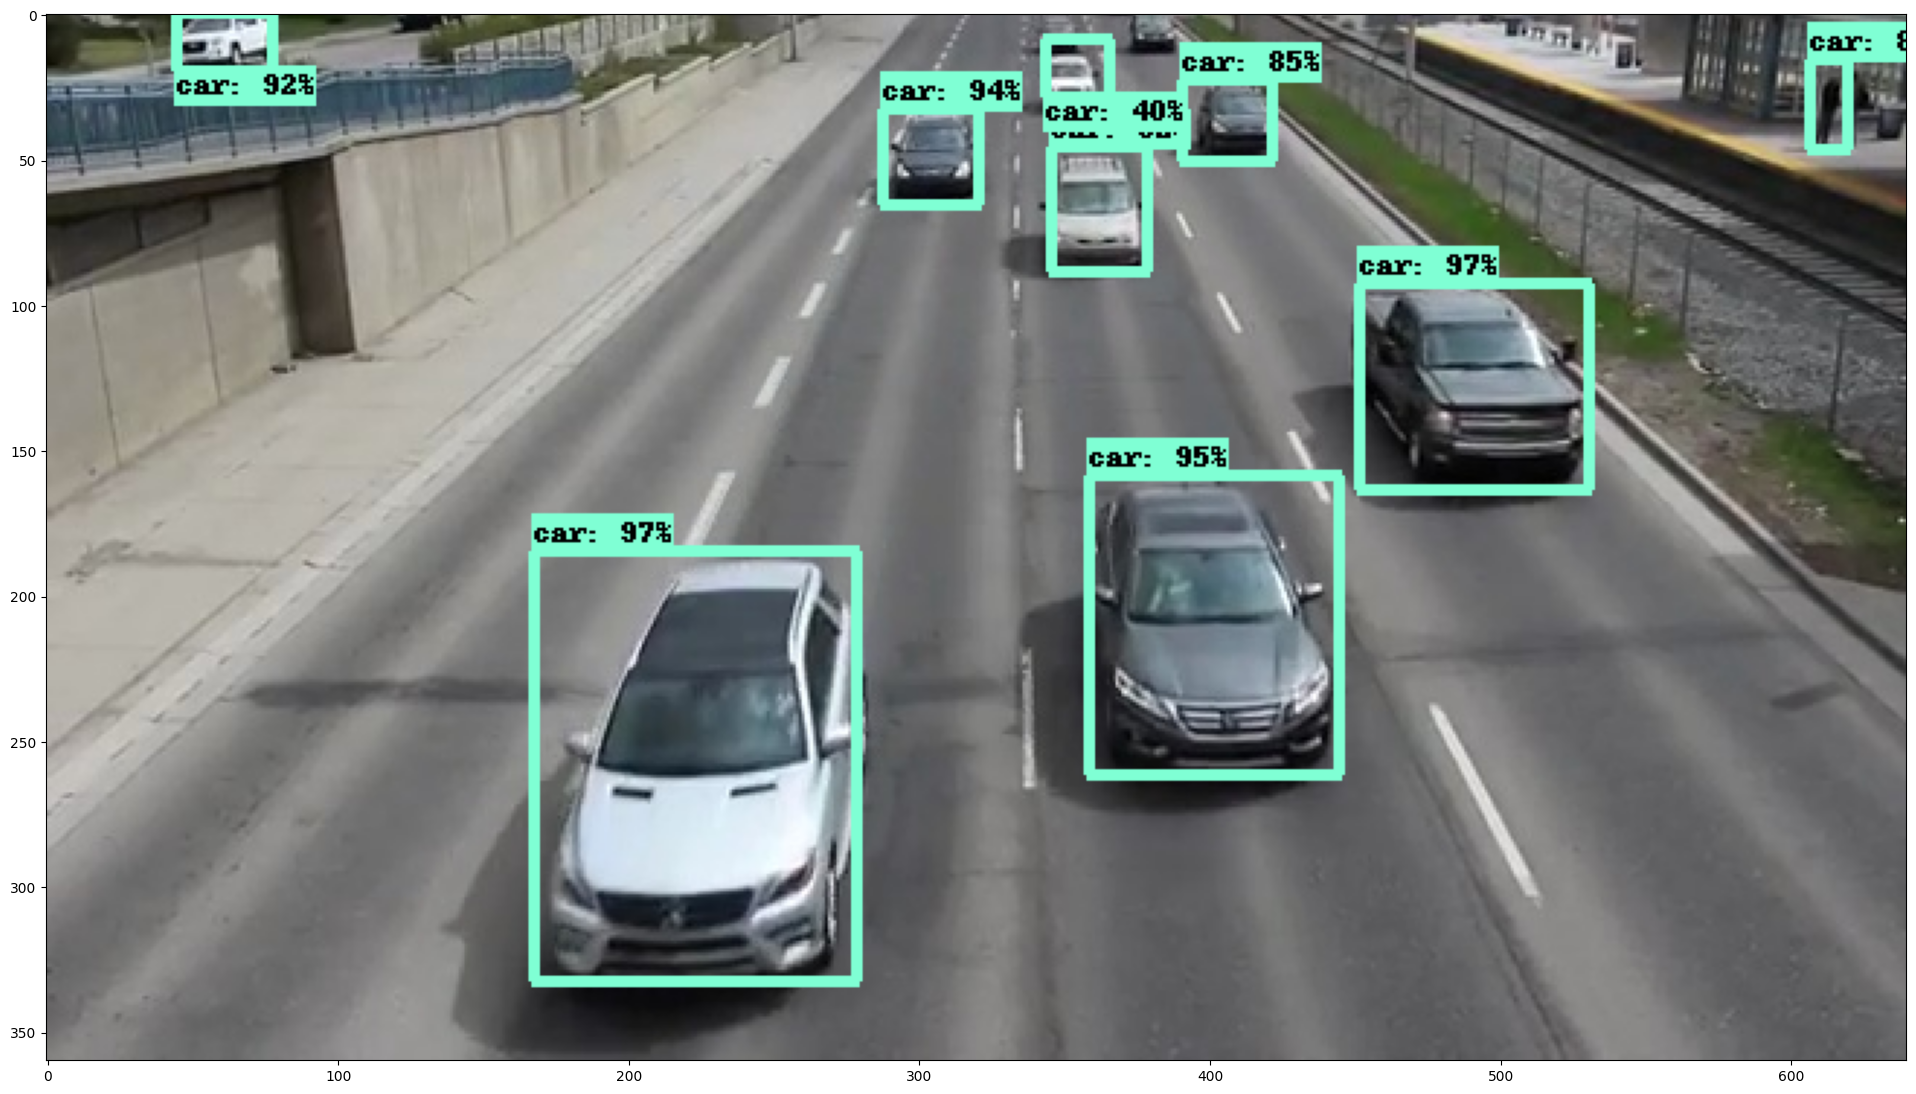

In [117]:
# Filter detections to only include vehicles (assuming vehicles have class ID 3)
vehicle_indices = np.arange(len(result['detection_classes'][0]))  # All detections are considered vehicles
vehicle_boxes = result['detection_boxes'][0]
vehicle_scores = result['detection_scores'][0]

# Set all class labels to 'vehicle'
class_labels = ['vehicle' for _ in vehicle_indices]

# Set boundary color to red
boundary_color = 'red'
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections[0],
    vehicle_boxes,
    np.ones_like(vehicle_indices) * 3,  # Class ID for vehicles
    vehicle_scores,
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=.30,  # Adjust this threshold as needed
    agnostic_mode=False,
)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()